(256, 1000)


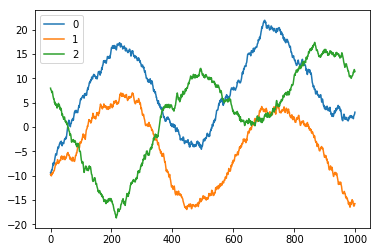

In [138]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

batch_size = 256
f = 2
timesteps = 1000
batch_x = []
batch_y = []
for i in range(batch_size):
    phase = np.random.uniform(-0.5, 0.5, 1)
    x = np.linspace(0, 1, timesteps) + phase
    y = np.sin(2*np.pi*x*f) * 10
    y = y + np.random.uniform(-0.5, 0.5, timesteps).cumsum()
    batch_x.append(x)
    batch_y.append(y)
    
batch_x = np.asarray(batch_x)    
batch_y = np.asarray(batch_y)


# plt.plot(np.arange(0, 1000, 1), batch_y[0])
# plt.xlabel('time')
# plt.ylabel('value')
# plt.show()
print(batch_y.shape)
df = pd.DataFrame(batch_y)
df.iloc[0:3].T.plot()

In [148]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-9.358235,-9.757756,-9.290321,-8.921442,-8.793539,-8.845784,-8.463424,-8.069351,-7.731432,-7.354233,...,2.133113,2.182726,2.091882,1.968052,1.723520,2.232034,2.377379,2.523061,2.683027,3.060812
1,-9.750399,-9.688414,-9.986394,-10.030095,-9.513360,-9.696869,-9.429767,-9.431443,-9.497092,-9.206766,...,-14.927789,-15.260983,-15.167878,-15.517244,-15.902316,-16.220073,-15.793346,-16.184911,-15.827057,-15.743909
2,7.997069,7.685382,7.613103,7.513328,7.121508,7.081309,7.328408,6.821102,6.422224,6.122802,...,10.509452,10.585032,10.691925,11.071053,11.355138,11.226040,11.556191,11.835332,11.661639,11.425387
3,-3.488149,-3.243332,-3.244692,-3.157761,-3.660025,-3.279898,-3.665502,-4.138765,-4.217417,-4.250368,...,5.118525,5.245308,5.494082,4.902872,4.527596,4.625133,4.457404,3.912815,4.081108,4.226320
4,-9.247527,-9.058328,-8.976522,-8.607749,-8.663883,-8.998836,-9.488692,-9.239603,-9.629128,-10.123276,...,-15.501865,-15.202981,-15.121808,-14.801411,-14.400380,-14.792526,-14.912487,-15.430482,-15.776674,-15.337961


In [156]:
df[[0,1]].head()

,0,1
0,-9.358235,-9.757756
1,-9.750399,-9.688414
2,7.997069,7.685382
3,-3.488149,-3.243332
4,-9.247527,-9.058328


In [161]:
df[[0,1]].diff().head()

,0,1
0,NaN,NaN
1,-0.392164,0.069343
2,17.747468,17.373796
3,-11.485218,-10.928714
4,-5.759377,-5.814996


In [163]:
df[[0,1]].pct_change().head()

,0,1
0,NaN,NaN
1,0.041906,-0.007106
2,-1.820179,-1.793255
3,-1.436178,-1.422013
4,1.651127,1.792908


In [206]:
df = pd.DataFrame([[100, 90, -90],[-100, -90, 90]]).T

In [207]:
df

,0,1
0,100,-100
1,90,-90
2,-90,90


In [208]:
df.diff()

,0,1
0,NaN,NaN
1,-10.0,10.0
2,-180.0,180.0


In [225]:
(df.shift(-1) - df) / df.abs()

,0,1
0,-0.1,0.1
1,-2.0,2.0
2,NaN,NaN


In [12]:
from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import pandas as pd
from game import Game

num_periods = 15
f_horizon = 1

num_input = 1
state_size = 50
num_classes = 3
output = 1
dropout = 0.5
num_layers = 2

num_epochs = 50
batch_size = 32
num_batches = 300
learning_rate = 0.001

random.seed(111)

# onehot = np.identity(3)
def generate_batch(batch_size, num_periods, f_horizon):
    x_batches = np.random.uniform(-10, 10, size=[batch_size, num_periods]).cumsum(axis=1).reshape([-1, num_periods, 1])
    y_batches = np.random.choice(num_classes, batch_size)
    return x_batches, y_batches


x, y = generate_batch(batch_size, num_periods, f_horizon)

print('X-shape: {}'.format(x.shape))
print('Y-shape: {}'.format(y.shape))


/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


X-shape: (32, 15, 1)
Y-shape: (32,)


In [3]:
# Create model
def create_model(batchX, batchY, advantage):
    conv1 = tf.layers.conv1d(inputs=batchX, data_format='channels_last', filters=18, kernel_size=2, strides=1, padding='same', activation = tf.nn.tanh)
    conv2 = tf.layers.conv1d(inputs=conv1, data_format='channels_last', filters=36, kernel_size=2, strides=1, padding='same', activation = tf.nn.tanh)
    flat = tf.reshape(conv2, (-1, 36*num_periods))
    logits = tf.layers.dense(flat, 3)

    outputs = tf.multinomial(logits, 1)
    logprob = -tf.nn.sparse_softmax_cross_entropy_with_logits(labels=batchY, logits=logits)
    loss = -tf.reduce_mean(logprob * advantage)
    return loss, outputs, logits


# Define placeholders
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, num_periods, num_input], name='PL_X')
batchY_placeholder = tf.placeholder(tf.int32, [batch_size], name='PL_Y')
advantage_placeholder = tf.placeholder(tf.float32, [batch_size], name='PL_ADV')

# Build model
loss, outputs, logits = create_model(batchX_placeholder, batchY_placeholder, advantage_placeholder)

# Build training step
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_step = optimizer.minimize(loss)



Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [4]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()
    
    x, y = generate_batch(batch_size, num_periods, f_horizon)
    
    _loss, _logits, _outputs = sess.run([loss, logits, outputs], feed_dict={
                    batchX_placeholder: x,
                    batchY_placeholder: y,
                    advantage_placeholder: y
                })



In [5]:
_logits.shape

(32, 3)

In [6]:
_outputs.shape

(32, 1)

In [ ]:
env = Game(batch_size, num_periods)
something = env.play(x, _outputs[0])
print(something)
print(len(something))